In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
from protein.LipidLeafletWithProtein_builtOn2 import LipidLeafletWithProtien as LipidLeaflet
from protein.protrusion import Protrusion

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting
csv
cvs-collecting


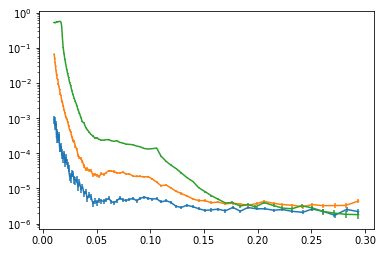

In [2]:
# dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
# dataD2o.name="d2o"
# dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
# dataPmw.name="pmw"

dataAcmw = Data1D(data=di.data_in("protein/54613_14edit.txt"))
dataAcmw.name="acm"
dataPmw = Data1D(data=di.data_in("protein/54616_17edit.txt"))
dataPmw.name="pmw"
dataD2o = Data1D(data=di.data_in("protein/10_11_d2o.txt"))
dataD2o.name="d2o"
plt.errorbar(dataAcmw.data[0],dataAcmw.data[1],dataAcmw.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.07, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
acmw = SLD(0.00, "ACMW")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.463, 6.35))#bounds=(3, 6.35)) # bounds=(5.9, 6.35))
pmw.real.setp(vary=True, bounds=(1.743, 2.957))#bounds=(1., 3.))
acmw.real.setp(vary=True, bounds=(-0.607, 0.607))#bounds=(-1, 1))

apm = Parameter(value=75, name='%s - area_per_molecule' % name,
                bounds=(60, 150), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,
            bounds=(3, #(1-0.75)*vm_tails.value/apm.value,
                    9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,
            bounds=(9, #(1-0.75)*vm_heads.value/apm.value,
                    20), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_top = Parameter(value=2,
            name='%s - rough_top' % name,
            bounds=(0,10), vary=True)
rough_bot = rough_top
# rough_bot = Parameter(value=2.0,
#             name='%s - rough_bot' % name,
#             bounds=(0,10), vary=True)

waters_per_head = Parameter(
            value=2.8,
            name="{} - Waters Per Head".format(name),
            bounds=(0, 20), vary=True)

waters_per_tail = Parameter(
            value=1,
            name="{} - Waters Per Tail".format(name),
            bounds=(0, 10), vary=True)

# b_mscl = Parameter(
#             value= ,
#             name="{} - b_protein_real".format(name),
#             vary=False)

vm_mscl = Parameter(
            value=74937.5, # + 19749
            name="{} - volume_protein".format(name),
            vary=False)

PLRatio = Parameter(
            value= 0.5,
            name="{} - ratio protein to bilayer".format(name),
            bounds=(0.25, 1),vary=True)

namePro = "Protrusion"
vol_protrusion = Parameter(
            value= 19749,
            name="{} - protien volume".format(namePro),
            vary=False)

protrusion_thick = Parameter(
            value= 20,
            name="{} - protrusion thickness".format(namePro),
            bounds=(5, 100),vary=True)

protrusion_rough = Parameter(
            value= 2,
            name="{} - protrusion roughness".format(namePro),
            bounds=(0, 20),vary=True)

protrusion_volfrac = Parameter(
            value= 0.5,
            name="{} - protrusion volfrac".format(namePro),
            bounds=(0, 1),vary=True)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent


# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, d2o, d2o,
    reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, d2o, d2o,
    reverse_monolayer=True, name="lower_lipid_d2o")

right_protrusion_d2o = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=d2o,  name=namePro+" d2o",
    vfsolv=protrusion_volfrac)


# head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, pmw, pmw,
    reverse_monolayer=False, name="upper_lipid_pmw")

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, pmw, pmw,
    reverse_monolayer=True, name="lower_lipid_pmw")

right_protrusion_pmw = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=pmw,  name=namePro+" pmw",
    vfsolv=protrusion_volfrac)


upper_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, acmw, acmw,
    reverse_monolayer=False, name="upper_lipid_acmw")

lower_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_bot, rough_bot,
    vm_water, waters_per_head, waters_per_tail,
    vm_mscl, PLRatio, acmw, acmw,
    reverse_monolayer=True, name="lower_lipid_acmw")

right_protrusion_acmw = Protrusion(thick=protrusion_thick,
    rough=protrusion_rough, vol_protein=vol_protrusion,
    PLratio=PLRatio, solventSLD=acmw,  name=namePro+" acmw",
    vfsolv=protrusion_volfrac)

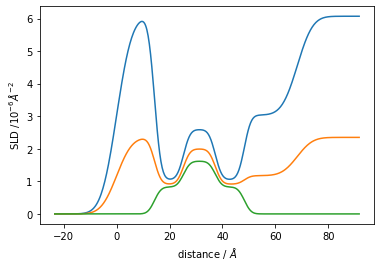

________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.07          , bounds=[5.463, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0, 20]>
<Parameter:'D2O - volfrac solvent', value=

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ACMW'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:     'ACMW'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter: 'ACMW - sld'  , value=0          , bounds=[-0.607, 0.607]>
<Parameter: 'ACMW - isld' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_precedi

In [5]:
solution_thickness = Parameter(value=14.3, bounds=(6, 25), vary=True,
            name='thickness_solution')

rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')

structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | right_protrusion_d2o  | d2o(solution_thickness, rough_preceding_solution)
structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | right_protrusion_pmw  | pmw(solution_thickness, rough_preceding_solution)
structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | right_protrusion_acmw | acmw(solution_thickness, rough_preceding_solution)

# structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | d2o(solution_thickness, rough_preceding_solution)
# structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness, rough_preceding_solution)
# structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
structure_pmw.name = "protein matched water"
structure_acmw.name = "ACMW"

plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o.parameters)
print(structure_pmw.parameters)
print(structure_acmw.parameters)

In [6]:
right_protrusion_d2o.parameters

Parameters(data=[Parameter(value=20.0, name='Protrusion - protrusion thickness', vary=True, bounds=Interval(lb=5, ub=100), constraint=None), Parameter(value=2.0, name='Protrusion - protrusion roughness', vary=True, bounds=Interval(lb=0, ub=20), constraint=None), Parameter(value=19749.0, name='Protrusion - protien volume', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.5, name='Protrusion - protrusion volfrac', vary=True, bounds=Interval(lb=0, ub=1), constraint=None)], name='Protrusion d2o')

In [7]:
print(structure_acmw.slabs())
print(structure_pmw.slabs())
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43000000e+01  0.00000000e+00  0.00000000e+00  4.60000000e+00
   0.00000000e+00]
 [ 1.10000000e+01  8.27286156e-01  4.95124626e-09  2.00000000e+00
   0.00000000e+00]
 [ 6.00000000e+00  1.61863156e+00 -1.75180685e-09  2.00000000e+00
   0.00000000e+00]
 [ 6.00000000e+00  1.61863156e+00 -1.75180685e-09  2.00000000e+00
   0.00000000e+00]
 [ 1.10000000e+01  8.27286156e-01  4.95124626e-09  2.00000000e+00
   0.00000000e+00]
 [ 2.00000000e+01  3.36824175e-06  0.00000000e+00  2.00000000e+00
   5.00000000e-01]
 [ 1.43000000e+01  0.00000000e+00  0.00000000e+00  4.60000000e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43000000e+01  2.35000000e+00  0.00000000e+00  4.60000000e+00
   0.00000000e+00]
 [ 1.10000000e+01  9.14853703e-01  4.95124626e-09  2.00000000e+00
   0.00000000e+00]
 [ 6.00000000e+00  1.99459200e+00 -1.75180685e-09  2.00000000e+0

In [8]:
print(dataD2o.y.max(), dataPmw.y.max(), dataAcmw.y.max())
print(dataD2o.y.min(), dataPmw.y.min(), dataAcmw.y.min())
model1 = ReflectModel(structure_d2o)
model1.scale.setp(0.5, vary=True, bounds=(0.45, 0.55)) #bounds=(0.5, 1)) #1./dataD2o.y.max()
if dataD2o.y.min()<0:
    d2oUpBound = dataD2o.y.min() * 0.2
    d2oLoBound = dataD2o.y.min() * 1.8
else:
    d2oUpBound = dataD2o.y.min() * 1.8
    d2oLoBound = dataD2o.y.min() * 0.2
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(d2oLoBound, d2oUpBound))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(0.5, vary=True, bounds=(0.45, 0.55)) #bounds=(0.25, 1))#(1./dataPmw.y.max(), vary=False))
if dataPmw.y.min()<0:
    pmwUpBound = dataPmw.y.min() * 0.2
    pmwLoBound = dataPmw.y.min() * 1.8
else:
    pmwUpBound = dataPmw.y.min() * 1.8
    pmwLoBound = dataPmw.y.min() * 0.2
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(pmwLoBound, pmwUpBound))

model3 = ReflectModel(structure_acmw)
model3.scale.setp(0.5, vary=True, bounds=(0.45, 0.55)) #bounds=(0.25, 1)) #1./dataAcmw.y.max(), vary=False)
if dataAcmw.y.min()<0:
    acmwUpBound = dataAcmw.y.min() * 0.2
    acmwLoBound = dataAcmw.y.min() * 1.8
else:
    acmwUpBound = dataAcmw.y.min() * 1.8
    acmwLoBound = dataAcmw.y.min() * 0.2
model3.bkg.setp(dataAcmw.y.min(),vary=True,bounds=(acmwLoBound, acmwUpBound))

objective1 = Objective(model1, dataD2o, transform=Transform("logY"))
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))
objective3 = Objective(model3, dataAcmw, transform=Transform("logY"))
gobjective = GlobalObjective([objective1,objective2,objective3])

0.562 0.0655 0.000924
1.8e-06 3.02e-06 1.73e-06


In [9]:
choose = 2
if choose==0:
    fitter = CurveFitter(gobjective)
    res = fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter import CFitter
    fitter = CFitter(gobjective)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results

49206it [36:48:23,  2.69s/it, batch: 5 | bound: 660 | nc: 548 | ncall: 26175075 | eff(%):  0.188 | loglstar: 137.423 < 145.381 < 138.214 | logz: 76.719 +/-  0.507 | stop:  0.948]           


In [10]:
# print(gobjective.parameters,"\n++++++++++++++++++++++++++++++++++++++++++++++++++++")

# [[print(param)] for param in gobjective.parameters]#varying_parameters()]

[[print(param)] for param in gobjective.varying_parameters()];

<Parameter:    'scale'    , value=0.54943          , bounds=[0.45, 0.55]>
<Parameter:     'bkg'     , value=2.16526e-06          , bounds=[3.6e-07, 3.24e-06]>
<Parameter:'thickness_solution', value=11.2308          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.09536          , bounds=[5.463, 6.35]>
<Parameter:'rough_preceding_solution', value=5.86265          , bounds=[0, 20]>
<Parameter:'bilayer - area_per_molecule', value=60.2517          , bounds=[60, 150]>
<Parameter:'bilayer - thickness_heads', value=9.20353          , bounds=[9, 20]>
<Parameter:'bilayer - thickness_tails', value=8.9677          , bounds=[3, 9]>
<Parameter:'bilayer - rough_top', value=5.88991          , bounds=[0, 10]>
<Parameter:'bilayer - Waters Per Head', value=5.7644          , bounds=[0, 20]>
<Parameter:'bilayer - Waters Per Tail', value=3.31181          , bounds=[0, 10]>
<Parameter:'bilayer - ratio protein to bilayer', value=0.99983          , bounds=[0.25, 1]>
<Parameter:'Protrusion - protrusion thi

In [11]:
if choose==2:
    print(res1)
else:
    print(res)
# [['bkg', nan],
#  ['thickness_solution', nan],
#  ['D2O - sld', nan],
#  ['rough_preceding_solution', nan],
#  ['bilayer - area_per_molecule', nan],
#  ['bilayer - thickness_heads', nan],
#  ['bilayer - thickness_tails', nan],
#  ['bilayer - rough_top', nan],
#  ['bilayer - Waters Per Head', nan],
#  ['bilayer - Waters Per Tail', nan],
#  ['bilayer - ratio protein to bilayer', nan],
#  ['bkg', nan],
#  ['Protein Matched Water - sld', nan],
#  ['bkg', nan],
#  ['ACMW - sld', nan]]

         niter: 49206
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 0.18798800003438385
       samples: array([[ 4.80224423e-01,  3.98487826e-07,  1.55579977e+01, ...,
         4.87224468e-01,  2.88477777e-06,  5.90285407e-01],
       [ 5.40087469e-01,  3.81817793e-07,  1.64749565e+01, ...,
         5.24934632e-01,  2.14663753e-06,  2.99650790e-01],
       [ 4.81296178e-01,  3.23389586e-06,  1.16692689e+01, ...,
         5.02148326e-01,  9.28948278e-07, -5.42913198e-01],
       ...,
       [ 5.49211056e-01,  2.28229840e-06,  1.15763906e+01, ...,
         5.40804650e-01,  2.43417820e-06,  3.79141707e-01],
       [ 5.48850051e-01,  2.30567320e-06,  1.15171809e+01, ...,
         5.36390141e-01,  2.41761327e-06,  3.71483697e-01],
       [ 5.46721150e-01,  2.22467615e-06,  1.15584272e+01, ...,
         5.42761580e-01,  2.42525982e-06,  3.59348741e-01]])
    samples_id: array([312, 296, 328, ..., 222, 271, 307], dtype=int64)
 samples_batch: array([0, 0, 0, ..., 0, 0, 0])
   

       0.26775921])


In [12]:
print(structure_acmw.slabs())
print(structure_pmw.slabs())
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.12307919e+01  3.60908424e-01  0.00000000e+00  5.86264677e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13488190e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.92064455e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.92064455e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13488190e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 5.49114131e+00  1.24170007e-02  0.00000000e+00  1.99991916e+01
   3.43862837e-02]
 [ 1.12307919e+01  3.60908424e-01  0.00000000e+00  5.86264677e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.12307919e+01  1.77369393e+00  0.00000000e+00  5.86264677e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13491422e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.91996087e-01 -4.32443433e-09  5.88990535e+0

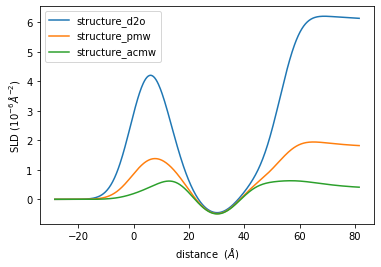

In [13]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

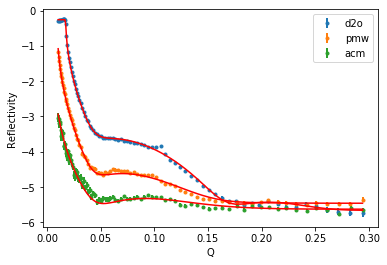

In [14]:
if choose==1:
    gobjective.plot(samples=300)
else:
    gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

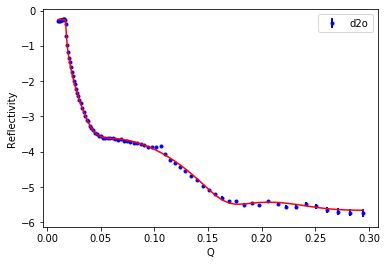

In [15]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

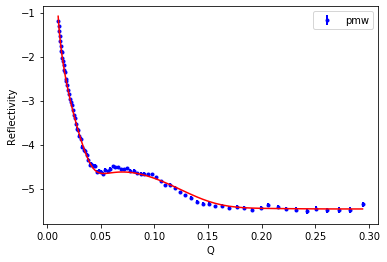

In [16]:
if choose==1:
    objective2.plot(samples=300)
else:
    objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

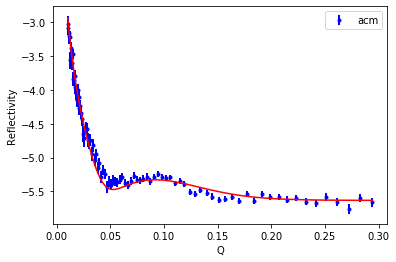

In [17]:
if choose==1:
    objective3.plot(samples=300)
else:
    objective3.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [18]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)
print("model3: acmw", model3.scale, model3.bkg)

model1: d2o <Parameter:    'scale'    , value=0.54943          , bounds=[0.45, 0.55]> <Parameter:     'bkg'     , value=2.16526e-06          , bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.546581          , bounds=[0.45, 0.55]> <Parameter:     'bkg'     , value=3.44747e-06          , bounds=[6.040000000000001e-07, 5.436e-06]>
model3: acmw <Parameter:    'scale'    , value=0.546796          , bounds=[0.45, 0.55]> <Parameter:     'bkg'     , value=2.33503e-06          , bounds=[3.46e-07, 3.114e-06]>


In [19]:
print(structure_d2o)

________________________________________________________________________________
Structure:       d2o      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=11.2308          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.09536          , bounds=[5.463, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=5.86265          ,

In [20]:
print(structure_pmw)

________________________________________________________________________________
Structure: protein matched water
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Protein Matched Water'
<Parameter:'thickness_solution', value=11.2308          , bounds=[6, 25]>
<Parameter:'Protein Matched Water - sld', value=1.77369          , bounds=[1.743, 2.957]>
<Parameter:'Protein Matched Water - isld', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_p

In [21]:
print(structure_acmw)

________________________________________________________________________________
Structure:      ACMW      
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:     'ACMW'     
<Parameter:'thickness_solution', value=11.2308          , bounds=[6, 25]>
<Parameter: 'ACMW - sld'  , value=0.360908          , bounds=[-0.607, 0.607]>
<Parameter: 'ACMW - isld' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=5.86265        

In [22]:
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.12307919e+01  6.09535862e+00  0.00000000e+00  5.86264677e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13501307e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.91786953e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.91786953e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13501307e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 5.49114131e+00  2.09606552e-01  0.00000000e+00  1.99991916e+01
   3.43862837e-02]
 [ 1.12307919e+01  6.09535862e+00  0.00000000e+00  5.86264677e+00
   0.00000000e+00]]


In [23]:
print(structure_pmw.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.12307919e+01  1.77369393e+00  0.00000000e+00  5.86264677e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13491422e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.91996087e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.91996087e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13491422e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 5.49114131e+00  6.09982124e-02  0.00000000e+00  1.99991916e+01
   3.43862837e-02]
 [ 1.12307919e+01  1.77369393e+00  0.00000000e+00  5.86264677e+00
   0.00000000e+00]]


In [24]:
print(structure_acmw.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.12307919e+01  3.60908424e-01  0.00000000e+00  5.86264677e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13488190e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.92064455e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 8.96770357e+00 -4.92064455e-01 -4.32443433e-09  5.88990535e+00
   0.00000000e+00]
 [ 9.20353448e+00  1.13488190e+00  1.59284411e-09  5.88990535e+00
   0.00000000e+00]
 [ 5.49114131e+00  1.24170007e-02  0.00000000e+00  1.99991916e+01
   3.43862837e-02]
 [ 1.12307919e+01  3.60908424e-01  0.00000000e+00  5.86264677e+00
   0.00000000e+00]]


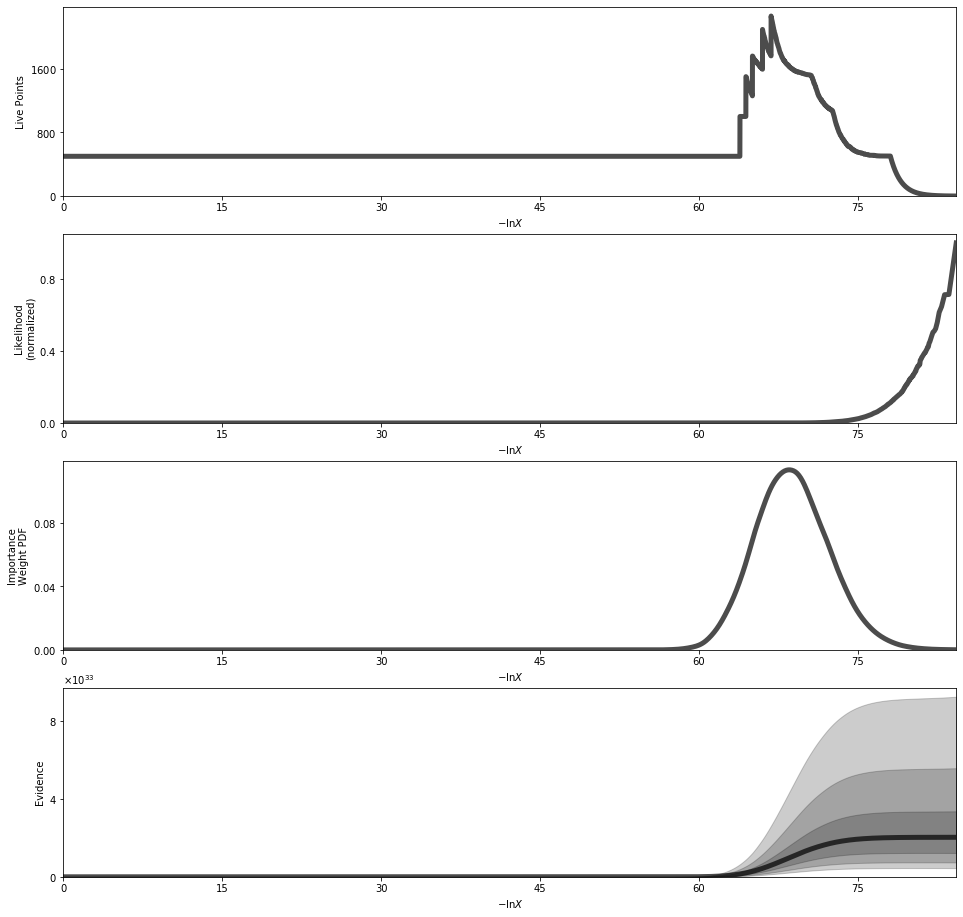

In [25]:
if choose==2:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [33]:
if choose==2:
    print("max(-ln(X)) =", -min(res1["logvol"])) # -min(res1["logvol"] = max(-ln(X))
#     print(re)
    print("max(logz), evidence =", max(res1["logz"]))

max(-ln(X)) = 84.30006409966845
max(logz), evidence = 76.69084512745772


In [27]:
#gobjective.varying_parameters()
[[param.name,param.value] for param in gobjective.varying_parameters()]

[['scale', 0.5494304385714426],
 ['bkg', 2.1652587825073935e-06],
 ['thickness_solution', 11.23079192156277],
 ['D2O - sld', 6.0953586167754645],
 ['rough_preceding_solution', 5.8626467723831945],
 ['bilayer - area_per_molecule', 60.25167831641158],
 ['bilayer - thickness_heads', 9.203534475918625],
 ['bilayer - thickness_tails', 8.967703571736447],
 ['bilayer - rough_top', 5.889905354582819],
 ['bilayer - Waters Per Head', 5.764395406776275],
 ['bilayer - Waters Per Tail', 3.3118125096557005],
 ['bilayer - ratio protein to bilayer', 0.9998300995737128],
 ['Protrusion - protrusion thickness', 5.491141309527245],
 ['Protrusion - protrusion roughness', 19.999191562735206],
 ['Protrusion - protrusion volfrac', 0.034386283745434364],
 ['scale', 0.5465805831511448],
 ['bkg', 3.4474729280463756e-06],
 ['Protein Matched Water - sld', 1.7736939265111207],
 ['scale', 0.5467956587566717],
 ['bkg', 2.3350276148149474e-06],
 ['ACMW - sld', 0.36090842406134005]]

I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"protein" and called "LipidLeafletWithProtien"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
1 'scale',\
2 'bkg',\
3 'mono, dodab - area_per_molecule',\
4 'mono, dodab - thickness heads',\
5 'mono, dodab - thickness_tails',\
6 'mono, dodab - roughness',\
7 'mono, dodab - D2O in head - sld',\
8 'mono, dodab Waters Per Head',\
9 'D2O - sld',\
10 'bilayer - area_per_molecule',\
11 'bilayer - thickness_heads',\
12 'bilayer - thickness_tails',\
13 'bilayer - rough_top',\
14 'D2O in bilayer - sld',\
15 'bilayer Waters Per Head',\
16 'scale',\
17 'bkg',\
18 'mono, dodab - Protein Matched Water in head - sld',\
19 'Protein Matched Water - sld',\
20 'bilayer - rough_bot',\
21 'Protein Matched Water in bilayer - sld'

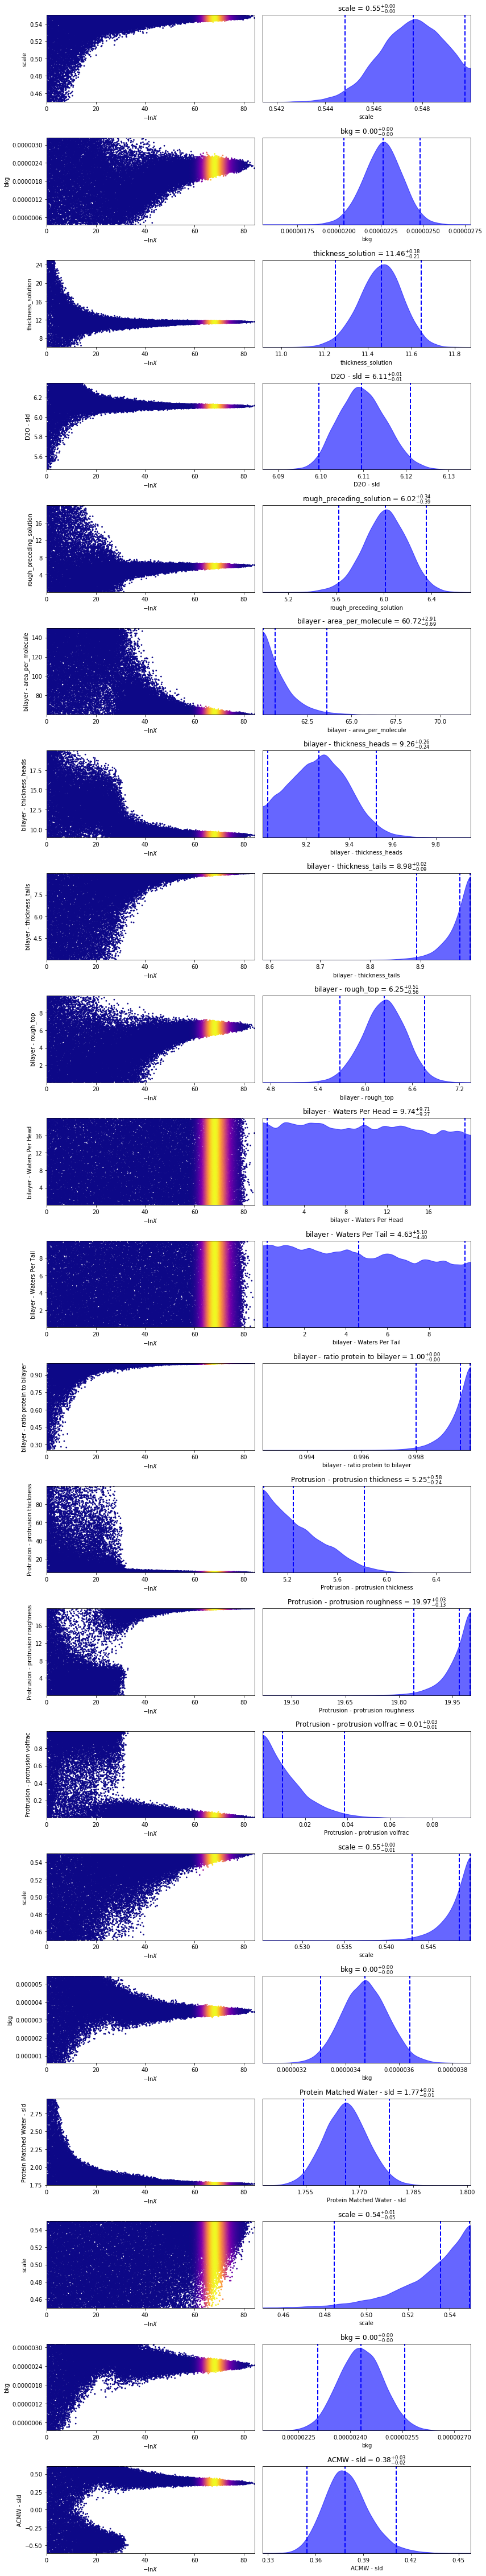

In [28]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, #truths=np.zeros(fitter.nDim()),
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

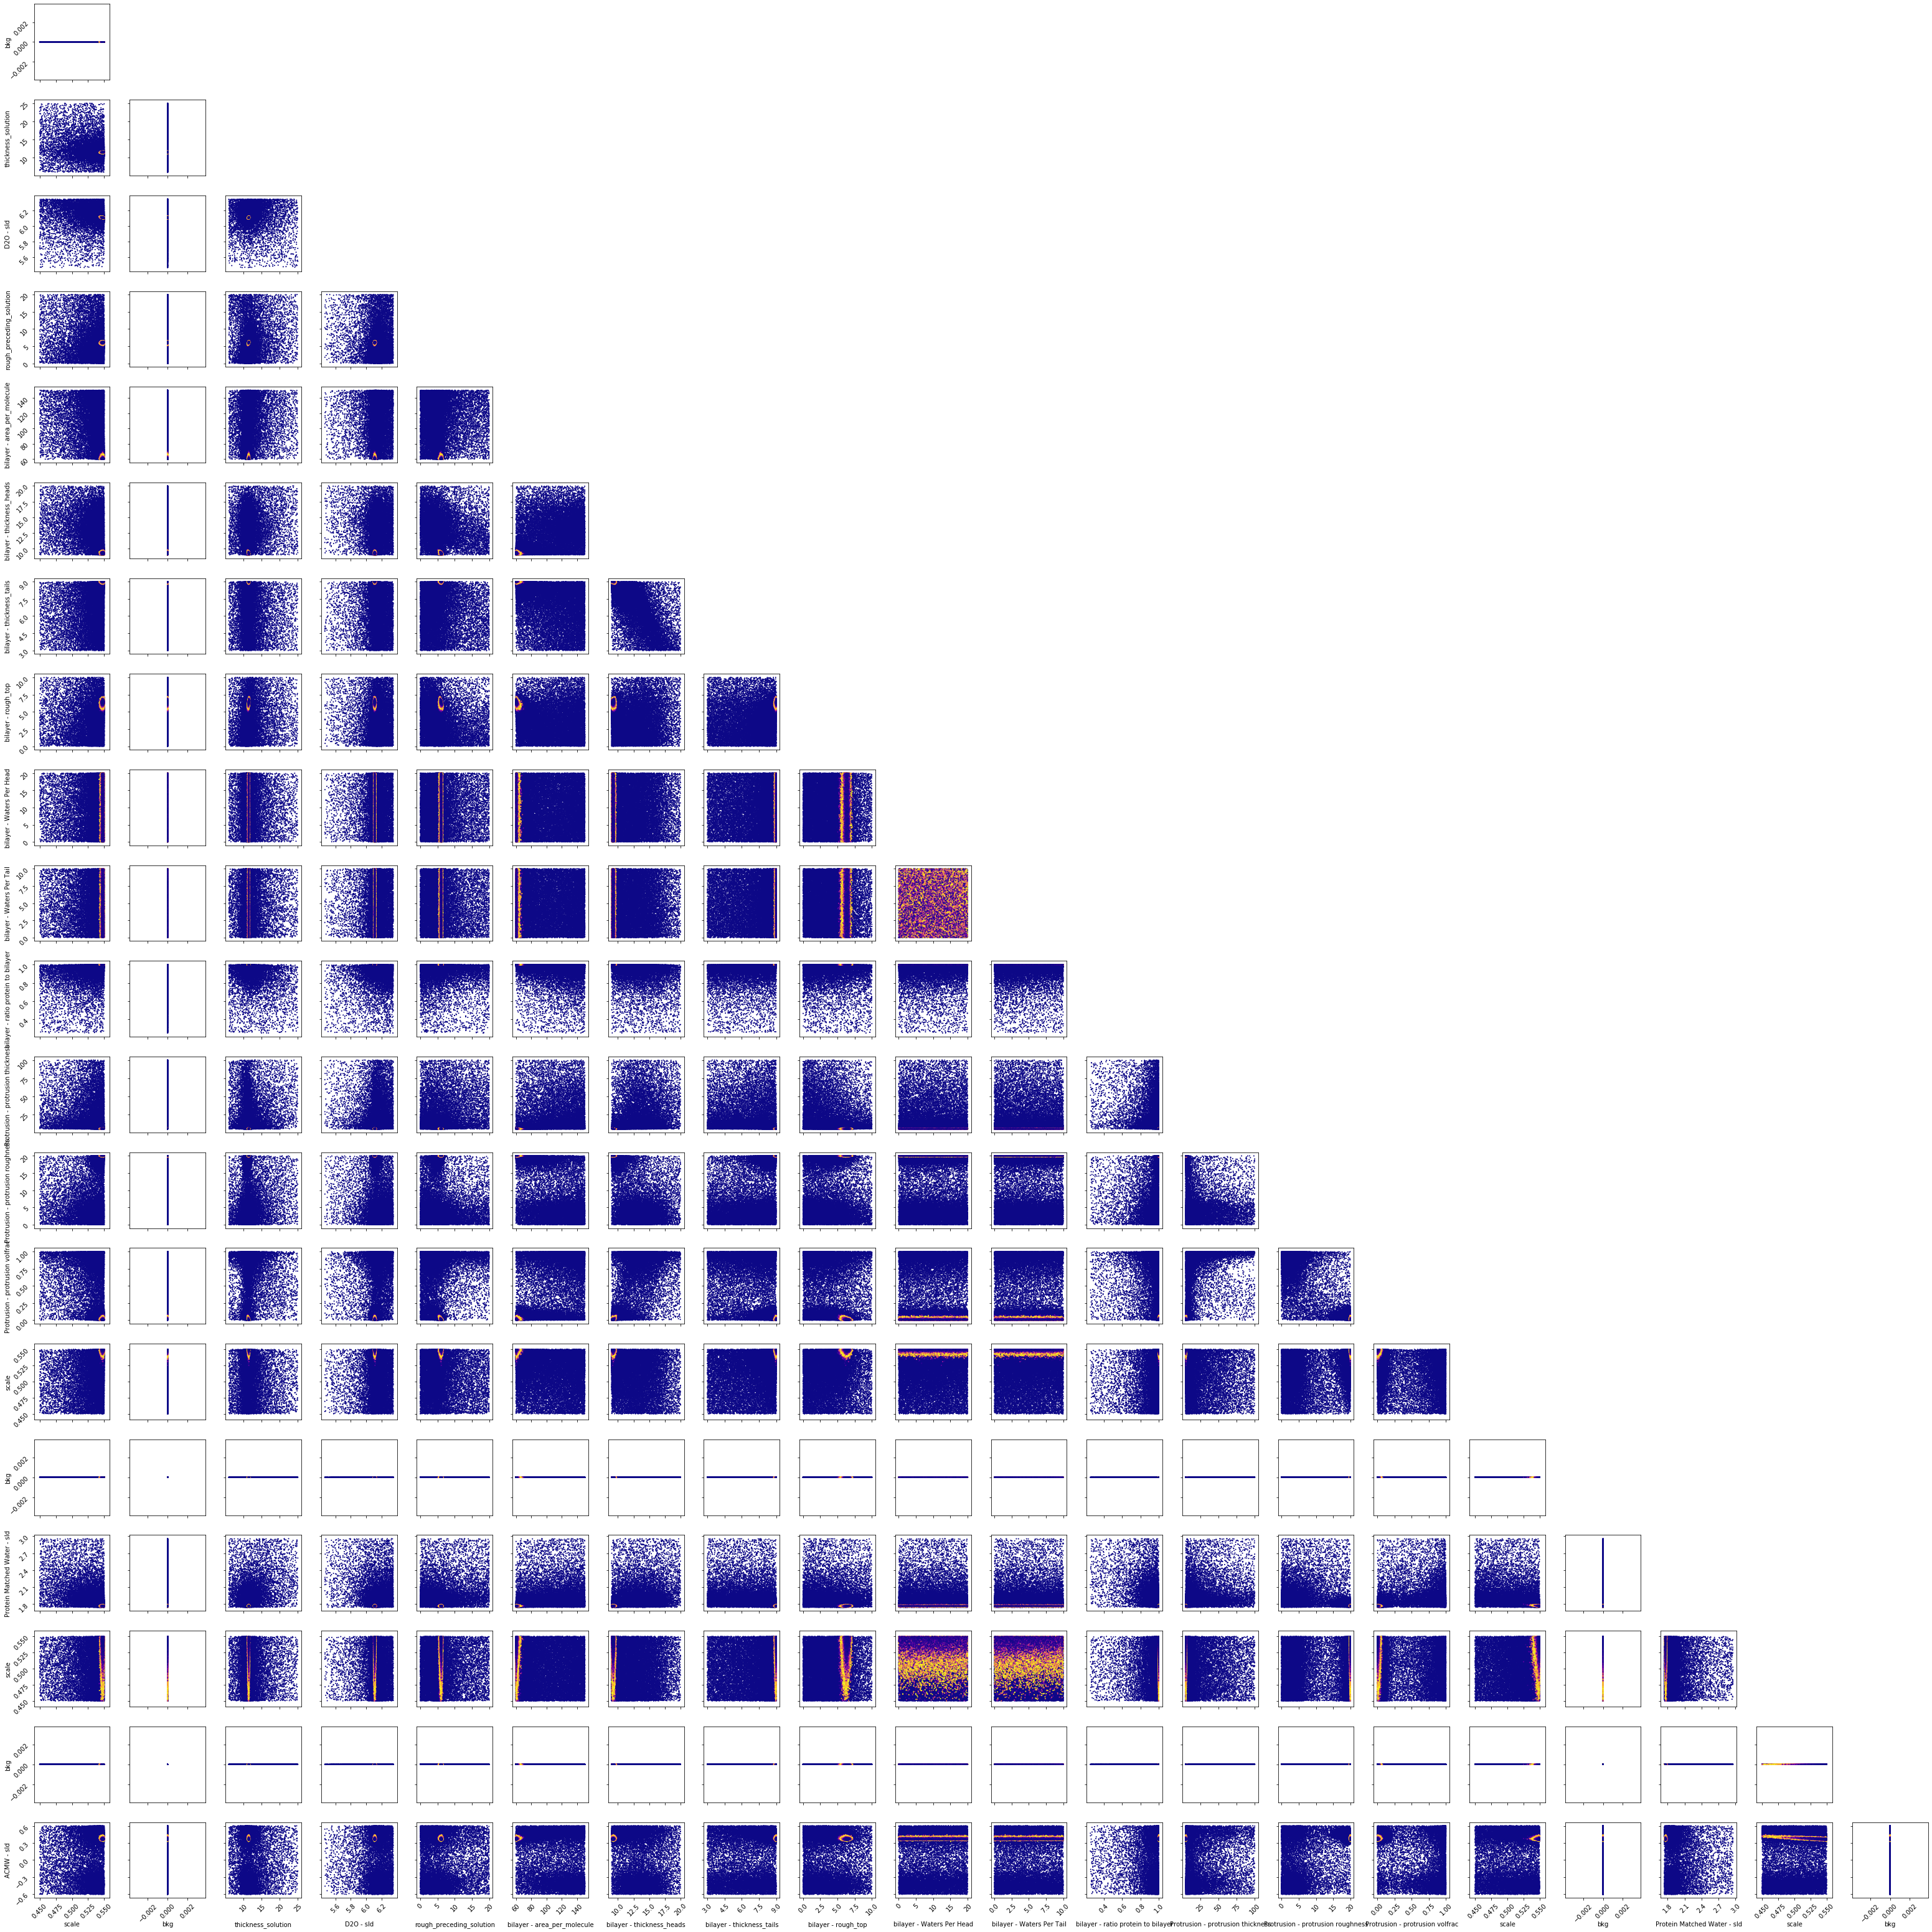

In [29]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.cornerpoints(res1, labels = labels#, #truths=np.zeros(fitter.nDim()),
                                 #show_titles=True,
                                 #trace_cmap='plasma',
                                 #quantiles=[0.025, 0.5, 0.975]
                                   )
    fig.tight_layout()